In [1]:
%load_ext autoreload
%autoreload 2
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from pathlib import Path
import os
from rqdatac import *
from rqfactor import *
from rqfactor import Factor
from rqfactor.extension import *

init("13522652015", "123456")
import rqdatac

from tqdm import *

import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = [
    "Arial Unicode MS",
    "PingFang SC",
    "Hiragino Sans GB",
    "STHeiti",
    "DejaVu Sans",
]
plt.rcParams["axes.unicode_minus"] = False

import warnings

warnings.filterwarnings("ignore")

In [35]:
# 动态券池
def INDEX_FIX(start_date, end_date, index_item):
    """
    :param start_date: 开始日 -> str
    :param end_date: 结束日 -> str
    :param index_item: 指数代码 -> str
    :return index_fix: 动态因子值 -> unstack
    """

    index_fix = pd.DataFrame(
        {
            k: dict.fromkeys(v, True)
            for k, v in index_components(
                index_item, start_date=start_date, end_date=end_date
            ).items()
        }
    ).T

    index_fix.fillna(False, inplace=True)
    index_fix.index.names = ["datetime"]

    return index_fix

In [36]:
# 研究时间
start_date = "2015-01-01"
end_date = "2025-07-01"

# 基准指数
index_item = "000852.XSHG"
change_day = 20
month_day = 20
year_day = 252

# 券池
stock_universe = INDEX_FIX(start_date, end_date, index_item)
stock_list = stock_universe.columns.tolist()
date_list = stock_universe.index.tolist()

In [38]:
get_price(
    stock_list,
    date_list[0],
    date_list[-1],
    adjust_type="none",
    fields=["open", "limit_up"],
)

open  limit_up
order_book_id date                       
000007.XSHE   2015-01-05  14.51     16.06
              2015-01-06  14.45     15.97
              2015-01-07  14.34     15.70
              2015-01-08  14.58     16.05
              2015-01-09  14.55     16.04
...                         ...       ...
688717.XSHG   2025-06-25  53.50     64.00
              2025-06-26  52.75     63.48
              2025-06-27  51.26     61.40
              2025-06-30  52.00     62.08
              2025-07-01  53.60     64.60

[5789392 rows x 2 columns]

In [5]:
factor_definition = Factor("net_profit_ttm_0") / Factor("equity_parent_company_ttm_0")
raw_factor = execute_factor(factor_definition, stock_list, start_date, end_date)

KeyboardInterrupt: 

In [40]:
# 基本面因子
# 全部资产现金回收率 = 经营性现金流/总资产
# cfoa = Factor("cash_flow_from_operating_activities_mrq_0") / Factor(
#     "total_assets_mrq_0"
# )
# factor_name = "cfoa_mrq_0"
roe = Factor("net_profit_ttm_0") / Factor("equity_parent_company_ttm_0")
factor_name = "roe_ttm"
factor_defintion = roe
raw_path = f"factor_lib/raw/{factor_name}_{index_item}_{start_date}_{end_date}.pkl"
neu_path = f"factor_lib/neu/{factor_name}_{index_item}_{start_date}_{end_date}.pkl"

In [41]:
try:
    factor_clean = pd.read_picke(neu_path)
except:
    raw_factor = execute_factor(factor_defintion, stock_list, start_date, end_date)
    raw_factor.to_pickle(raw_path)
    factor_clean = data_clean(raw_factor, stock_universe, index_item)
    factor_clean.to_pickle(neu_path)
# 计算IC
ic, performance = calc_ic(factor_clean, change_day, index_item, factor_name)

{'name': 'roe_ttm', 'change_day': 20, 'IC mean': 0.0257, 'IC std': 0.0853, 'ICIR': 0.3008, 'IC>0': 0.6203, 'ABS_IC>2%': 0.7757, 't_stat': 15.1233}


 当前：2540 / 总量：2548

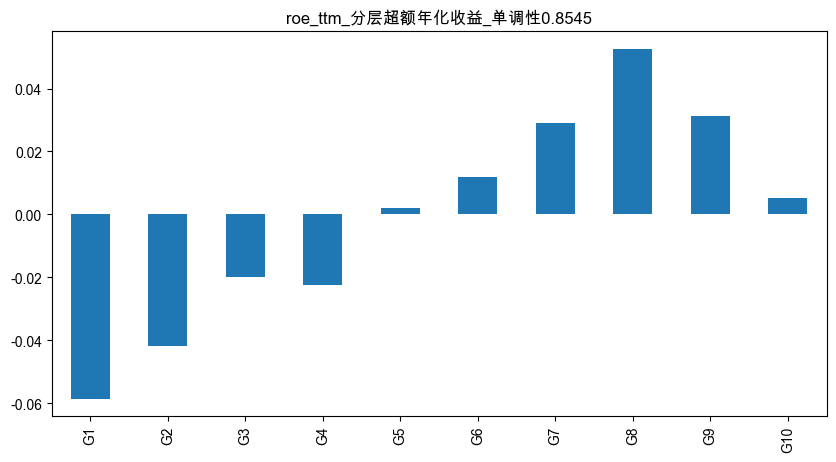

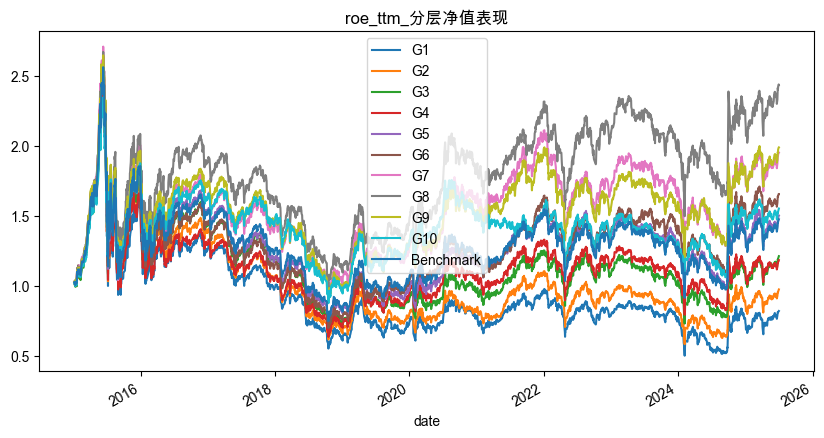

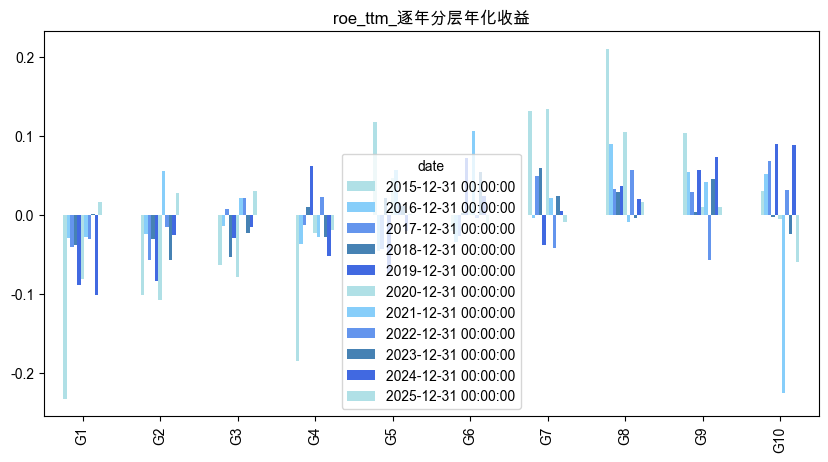

In [38]:
# 分组回测
group_return, turnover = group_g(
    factor_clean, change_day, 10, index_item, name=factor_name
)